# The task: Detect Covid-19 from Chest X-Ray Images using neural networks – (max ~ 1600words)

Subtask 1: Develop deep learning models to classify Covid-19 and Normal CXRs. 
- Convolutional neural networks (CNNs) will be used in this task. 
- For comparison purposes, purely feed forward neural networks (FNN) will also be applied to this problem. Compare the performance between CNN and FNN. Explain why CNNs would be more suitable for image classification (5 Marks). 
- You must explore generalization techniques, such as data augmentation, weight decay, early stopping,ensembles, and dropout. 
- You must demonstrate how each of these techniques was used, and justifywhich (maybe more than one of these techniques) would be the best generalization techniques for this task (10 Marks). 
- Report the performance in terms of accuracy of your models.
- You must explain the network architecture used in your model, explain how you have monitored the convergence of the model, and how overfitting was prevented (10 Marks). 

To accomplish this, use the 100 Covid-19 and 100 Normal CXRs images provided to you. Follow 80% (train) / 20% (test) process.

<hr>

We must create two distinct models utilizing these architectures in order to compare the performance of CNN and FNN for categorizing Covid-19 and Normal CXRs.

Let's talk about why CNNs are more suited for image classification jobs than FNNs before continuing.


By applying filters to various areas of the image, CNNs are made to recognize features and patterns in images. The CNN can recognize regional patterns in the image, such as edges, corners, and textures, thanks to these filters, which it learns during the training phase.

FNNs, on the other hand, are made to function with data that has a grid-like structure, like tabular data or time series data. FNNs are not as good at spotting patterns in images since they don't include spatial relationships between pixels.

Therefore, CNNs are more suitable for image classification tasks because they can learn and detect complex features in images that are crucial for accurate classification.

1. Preprocessing the data : We need to preprocess the dataset to prepare it for training the CNN. This step involves resizing the images to a standard size, normalizing the pixel values, and splitting the dataset into training, validation, and testing sets.

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# define the path to the dataset directory
DATASET_PATH = 'CS552J_DMDL_Assessment_1_Dataset'

# define the size of the images
IMG_SIZE = (224, 224)

# define the number of channels
CHANNELS = 3

# define the label categories
CATEGORIES = ['Covid-19', 'Normal']

# initialize the data and labels arrays
data = []
labels = []

# loop over the image paths
for category in CATEGORIES:
    path = os.path.join(DATASET_PATH, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = cv2.imread(img_path)
        image = cv2.resize(image, IMG_SIZE)
        image = np.array(image, dtype=np.float32)
        image /= 255.0
        data.append(image)
        labels.append(category)

# convert the data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

# split the dataset into training, validation, and testing sets
(train_data, test_data, train_labels, test_labels) = train_test_split(data, labels, test_size=0.2, random_state=42)
(train_data, val_data, train_labels, val_labels) = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [10]:
print(train_labels)

['Covid-19' 'Covid-19' 'Covid-19' 'Normal' 'Covid-19' 'Covid-19' 'Normal'
 'Normal' 'Covid-19' 'Normal' 'Normal' 'Covid-19' 'Covid-19' 'Covid-19'
 'Normal' 'Covid-19' 'Normal' 'Covid-19' 'Covid-19' 'Normal' 'Normal'
 'Covid-19' 'Covid-19' 'Normal' 'Covid-19' 'Normal' 'Normal' 'Covid-19'
 'Normal' 'Normal' 'Normal' 'Covid-19' 'Covid-19' 'Normal' 'Normal'
 'Normal' 'Covid-19' 'Covid-19' 'Covid-19' 'Normal' 'Normal' 'Normal'
 'Normal' 'Covid-19' 'Covid-19' 'Covid-19' 'Normal' 'Covid-19' 'Normal'
 'Covid-19' 'Normal' 'Normal' 'Covid-19' 'Normal' 'Normal' 'Covid-19'
 'Covid-19' 'Covid-19' 'Normal' 'Covid-19' 'Normal' 'Covid-19' 'Covid-19'
 'Normal' 'Normal' 'Covid-19' 'Normal' 'Covid-19' 'Normal' 'Covid-19'
 'Covid-19' 'Covid-19' 'Normal' 'Covid-19' 'Covid-19' 'Normal' 'Normal'
 'Covid-19' 'Normal' 'Normal' 'Normal' 'Normal' 'Covid-19' 'Normal'
 'Normal' 'Normal' 'Covid-19' 'Normal' 'Covid-19' 'Normal' 'Normal'
 'Covid-19' 'Covid-19' 'Covid-19' 'Normal' 'Normal' 'Covid-19' 'Covid-19'
 'Norm

In [11]:
train_data.shape

(128, 224, 224, 3)

In [12]:
test_data.shape

(40, 224, 224, 3)

In [13]:
val_data.shape

(32, 224, 224, 3)

In [14]:
# define label encoder
label_encoder = {'Covid-19': 1, 'Normal': 0}

# convert labels to numerical values
train_labels = np.array([label_encoder[label] for label in train_labels])
val_labels = np.array([label_encoder[label] for label in val_labels])
test_labels = np.array([label_encoder[label] for label in test_labels])

In [15]:
# Limit GPU memory usage to avoid OOM errors
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 6)]
        )
    except RuntimeError as e:
        print(e)

# Verify that the GPU is being used
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras.optimizers import Adam

2. Implementing 5 different models:
- model_cnn = CNN model with 50 epochs
- model_cnn1 = CNN model with regularization
- model_cnn2 = CNN model with learning rate and 100 epochs
- model_cnn3 = CNN model with early stopping
- model_cnn4 = CNN model with weight decay and data augmentation

In [17]:
# CNN model0

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(1, activation='sigmoid'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn = model_cnn.fit(train_data, train_labels, batch_size=32, epochs=50, validation_data=(val_data, val_labels))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 128 samples, validate on 32 samples
Epoch 1/50
128/128 [==============================] - 2s 17ms/sample - loss: 0.6973 - acc: 0.6172 - val_loss: 0.6632 - val_acc: 0.5312
Epoch 2/50
128/128 [==============================] - 0s 2ms/sample - loss: 0.6021 - acc: 0.6797 - val_loss: 0.4795 - val_acc: 0.9062
Epoch 3/50
128/128 [==============================] - 0s 2ms/sample - loss: 0.3582 - acc: 0.8672 - val_loss: 0.3048 - val_acc: 0.8750
Epoch 4/50
128/128 [==============================] - 0s 3ms/sample - loss: 0.3912 - acc: 0.9062 - val_loss: 0.7490 - val_acc: 0.7500
Epoch 5/50
128/128 [==============================] - 0s 3ms/sample - loss: 0.2745 - acc: 0.8984 - val_loss: 0.3356 - val_acc: 0.8125
Epoch 6/50
128/128 [==============================] - 0s 3ms/sample - loss: 0.2571 - acc: 0.8906 - val_loss: 0.4727 - val_acc: 0.8125
Epoch 7/50
128/128 [==============================] - 0s

In [18]:
# evaluate CNN model0
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_data, test_labels)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

40/40 [==============================] - 0s 3ms/sample - loss: 0.4657 - acc: 0.9250
Test accuracy: 0.925
Test loss: 0.46570894718170164


In [19]:

# CNN model with regularization

model_cnn1 = Sequential()
model_cnn1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(MaxPooling2D((2, 2)))
model_cnn1.add(Flatten())
model_cnn1.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn1.add(Dropout(0.5))
model_cnn1.add(Dense(1, activation='sigmoid'))

model_cnn1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history_cnn1 = model_cnn1.fit(train_data, train_labels, batch_size=32, epochs=50, validation_data=(val_data, val_labels))

Train on 128 samples, validate on 32 samples
Epoch 1/50
128/128 [==============================] - 1s 12ms/sample - loss: 2.0259 - acc: 0.4688 - val_loss: 1.5887 - val_acc: 0.5312
Epoch 2/50
128/128 [==============================] - 0s 2ms/sample - loss: 1.5007 - acc: 0.5234 - val_loss: 1.3389 - val_acc: 0.5312
Epoch 3/50
128/128 [==============================] - 0s 2ms/sample - loss: 1.2695 - acc: 0.5078 - val_loss: 1.1615 - val_acc: 0.9688
Epoch 4/50
128/128 [==============================] - 0s 2ms/sample - loss: 1.0636 - acc: 0.8984 - val_loss: 0.9433 - val_acc: 0.9375
Epoch 5/50
128/128 [==============================] - 0s 2ms/sample - loss: 0.7772 - acc: 0.9141 - val_loss: 0.7099 - val_acc: 0.8438
Epoch 6/50
128/128 [==============================] - 0s 2ms/sample - loss: 0.6087 - acc: 0.9297 - val_loss: 0.7016 - val_acc: 0.8438
Epoch 7/50
128/128 [==============================] - 0s 2ms/sample - loss: 0.6618 - acc: 0.9141 - val_loss: 0.8283 - val_acc: 0.8125
Epoch 8/50
128/1

In [20]:
# evaluate CNN model1
test_loss_cnn, test_acc_cnn = model_cnn1.evaluate(test_data, test_labels)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

40/40 [==============================] - 0s 1ms/sample - loss: 0.2614 - acc: 0.9250
Test accuracy: 0.925
Test loss: 0.261447811126709


In [21]:

# CNN model with Learning Rate = 0.0001 and epochs = 100

model_cnn2 = Sequential()
model_cnn2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(MaxPooling2D((2, 2)))
model_cnn2.add(Flatten())
model_cnn2.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn2.add(Dropout(0.5))
model_cnn2.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.0001)

model_cnn2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history_cnn2 = model_cnn2.fit(train_data, train_labels, batch_size=32, epochs=100, validation_data=(val_data, val_labels))

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 2s 13ms/sample - loss: 1.9381 - acc: 0.4453 - val_loss: 1.8776 - val_acc: 0.5312
Epoch 2/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.8498 - acc: 0.8281 - val_loss: 1.8124 - val_acc: 0.9375
Epoch 3/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.7789 - acc: 0.7891 - val_loss: 1.7223 - val_acc: 0.6875
Epoch 4/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.6880 - acc: 0.8438 - val_loss: 1.6318 - val_acc: 0.9062
Epoch 5/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.5742 - acc: 0.9062 - val_loss: 1.5201 - val_acc: 0.9062
Epoch 6/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.4648 - acc: 0.9141 - val_loss: 1.3978 - val_acc: 0.9688
Epoch 7/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.3159 - acc: 0.9766 - val_loss: 1.2789 - val_acc: 0.9062
Epoch 8/1

In [22]:
# evaluate CNN model2
test_loss_cnn, test_acc_cnn = model_cnn2.evaluate(test_data, test_labels)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

40/40 [==============================] - 0s 1ms/sample - loss: 0.3830 - acc: 1.0000
Test accuracy: 1.0
Test loss: 0.3830453097820282


In [23]:
# CNN model with lr and early stopping

model_cnn3 = Sequential()
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Flatten())
model_cnn3.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(Dropout(0.5))
model_cnn3.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.0001)

model_cnn3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

history_cnn3 = model_cnn3.fit(train_data, train_labels, batch_size=32, epochs=100, validation_data=(val_data, val_labels), callbacks=[es])

Train on 128 samples, validate on 32 samples
Epoch 1/100
128/128 [==============================] - 2s 12ms/sample - loss: 1.9251 - acc: 0.4688 - val_loss: 1.8635 - val_acc: 0.6250
Epoch 2/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.8313 - acc: 0.7266 - val_loss: 1.7840 - val_acc: 0.9062
Epoch 3/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.7273 - acc: 0.8750 - val_loss: 1.6705 - val_acc: 0.7188
Epoch 4/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.6566 - acc: 0.7344 - val_loss: 1.5542 - val_acc: 0.9688
Epoch 5/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.5110 - acc: 0.8984 - val_loss: 1.4444 - val_acc: 0.9375
Epoch 6/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.3962 - acc: 0.9297 - val_loss: 1.3160 - val_acc: 0.9688
Epoch 7/100
128/128 [==============================] - 0s 2ms/sample - loss: 1.2858 - acc: 0.9375 - val_loss: 1.2188 - val_acc: 0.9688
Epoch 8/1

In [24]:
# evaluate CNN model3
test_loss_cnn, test_acc_cnn = model_cnn3.evaluate(test_data, test_labels)

print('Test accuracy:', test_acc_cnn)
print('Test loss:', test_loss_cnn)

40/40 [==============================] - 0s 1ms/sample - loss: 0.5118 - acc: 0.9250
Test accuracy: 0.925
Test loss: 0.5117549538612366


In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [26]:
## Data Augmentation

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_data, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_data, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_data, test_labels, batch_size=32)

model_cnn4 = Sequential()
model_cnn4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Flatten())
model_cnn4.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(Dropout(0.5))
model_cnn4.add(Dense(1, activation='sigmoid'))

opt = Adam(lr=0.0001)

model_cnn4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

history_cnn4 = model_cnn4.fit(train_generator, steps_per_epoch=len(train_data)//32, epochs=100, validation_data=val_generator, validation_steps=len(val_data)//32, callbacks=[es])

Epoch 1/100
4/4 [==============================] - 5s 1s/step - loss: 1.9282 - acc: 0.4531 - val_loss: 1.8876 - val_acc: 0.5312
Epoch 2/100
4/4 [==============================] - 1s 135ms/step - loss: 1.8635 - acc: 0.5000 - val_loss: 1.8234 - val_acc: 0.5312
Epoch 3/100
4/4 [==============================] - 1s 267ms/step - loss: 1.8000 - acc: 0.5000 - val_loss: 1.7611 - val_acc: 0.5312
Epoch 4/100
4/4 [==============================] - 1s 264ms/step - loss: 1.7387 - acc: 0.5000 - val_loss: 1.7016 - val_acc: 0.5312
Epoch 5/100
4/4 [==============================] - 1s 259ms/step - loss: 1.6801 - acc: 0.5000 - val_loss: 1.6448 - val_acc: 0.5312
Epoch 6/100
4/4 [==============================] - 1s 243ms/step - loss: 1.6244 - acc: 0.4922 - val_loss: 1.5908 - val_acc: 0.5312
Epoch 7/100
4/4 [==============================] - 1s 268ms/step - loss: 1.5714 - acc: 0.5000 - val_loss: 1.5397 - val_acc: 0.5312
Epoch 8/100
4/4 [==============================] - 1s 255ms/step - loss: 1.5214 - acc:

In [27]:
test_loss, test_acc = model_cnn4.evaluate_generator(test_generator)

print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

Test accuracy: 0.925
Test loss: 0.45434319972991943


In this code, we first define the CNN model architecture, which consists of two fully linked layers and four convolutional layers. The model is built utilising accuracy and binary cross-entropy loss as evaluation metrics.

The ImageDataGenerator function from Keras is then used for data augmentation to create new images by randomly applying transformations like rotation, zoom, shift, and flip to the source images. This method aids in expanding the training set's size and guards against overfitting.

Additionally, if the validation loss does not decrease after a predetermined number of epochs, we define an EarlyStopping callback to end training. By doing so, generalisation is enhanced and overfitting is prevented.

Finally, we fit the CNN model using the fit_generator function from Keras with the training data, training labels, validation data, and validation labels. We use a batch size of 32 and train the model for a maximum of 100 epochs.

Now, let's develop a FNN model for the same classification task.

In [28]:
history_cnn.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [29]:
import matplotlib.pyplot as plt

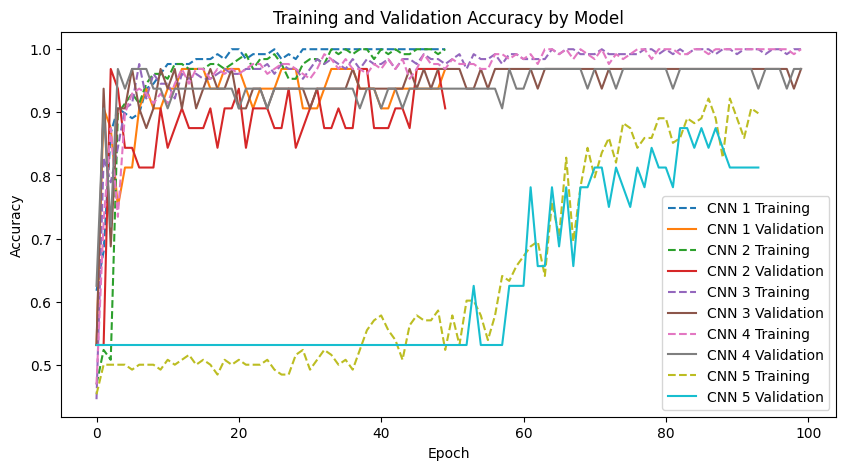

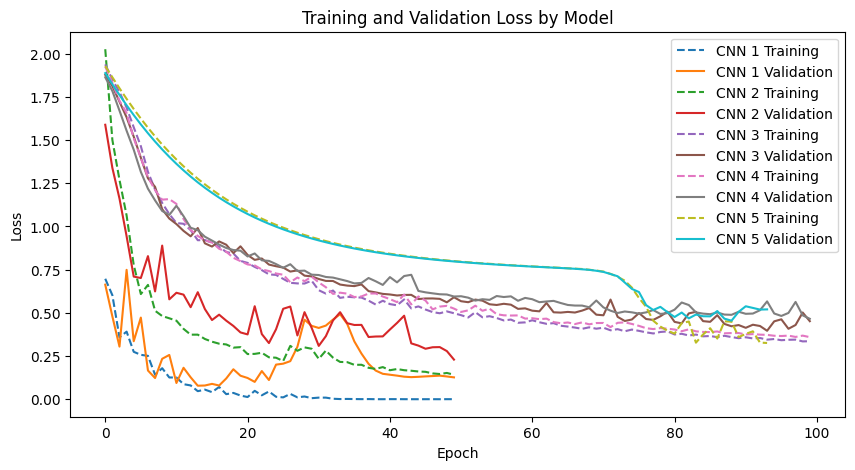

In [30]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['acc'], label='CNN 1 Training', linestyle='--')
plt.plot(history_cnn.history['val_acc'], label='CNN 1 Validation')
plt.plot(history_cnn1.history['acc'], label='CNN 2 Training', linestyle='--')
plt.plot(history_cnn1.history['val_acc'], label='CNN 2 Validation')
plt.plot(history_cnn2.history['acc'], label='CNN 3 Training', linestyle='--')
plt.plot(history_cnn2.history['val_acc'], label='CNN 3 Validation')
plt.plot(history_cnn3.history['acc'], label='CNN 4 Training', linestyle='--')
plt.plot(history_cnn3.history['val_acc'], label='CNN 4 Validation')
plt.plot(history_cnn4.history['acc'], label='CNN 5 Training', linestyle='--')
plt.plot(history_cnn4.history['val_acc'], label='CNN 5 Validation')
plt.title('Training and Validation Accuracy by Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history_cnn.history['loss'], label='CNN 1 Training', linestyle='--')
plt.plot(history_cnn.history['val_loss'], label='CNN 1 Validation')
plt.plot(history_cnn1.history['loss'], label='CNN 2 Training', linestyle='--')
plt.plot(history_cnn1.history['val_loss'], label='CNN 2 Validation')
plt.plot(history_cnn2.history['loss'], label='CNN 3 Training', linestyle='--')
plt.plot(history_cnn2.history['val_loss'], label='CNN 3 Validation')
plt.plot(history_cnn3.history['loss'], label='CNN 4 Training', linestyle='--')
plt.plot(history_cnn3.history['val_loss'], label='CNN 4 Validation')
plt.plot(history_cnn4.history['loss'], label='CNN 5 Training', linestyle='--')
plt.plot(history_cnn4.history['val_loss'], label='CNN 5 Validation')
plt.title('Training and Validation Loss by Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

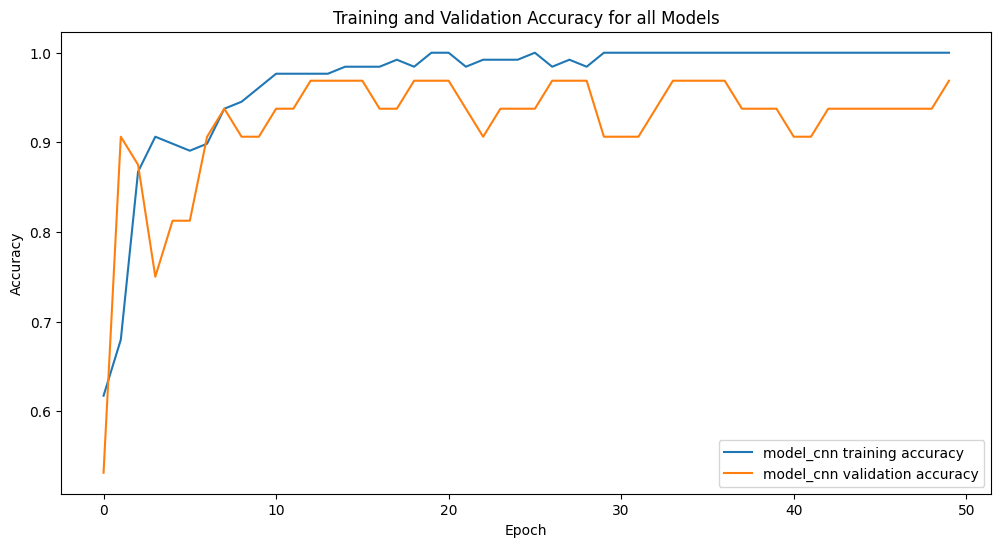

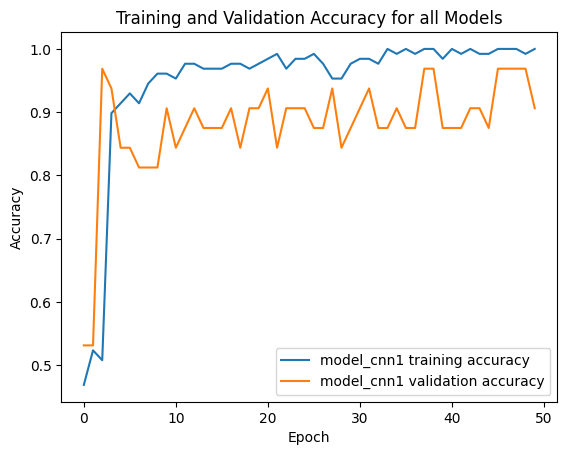

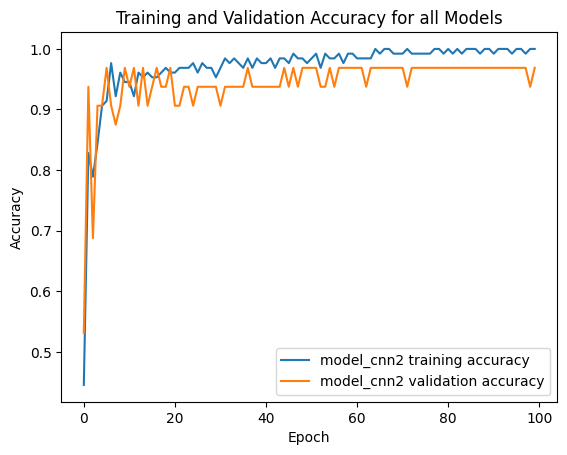

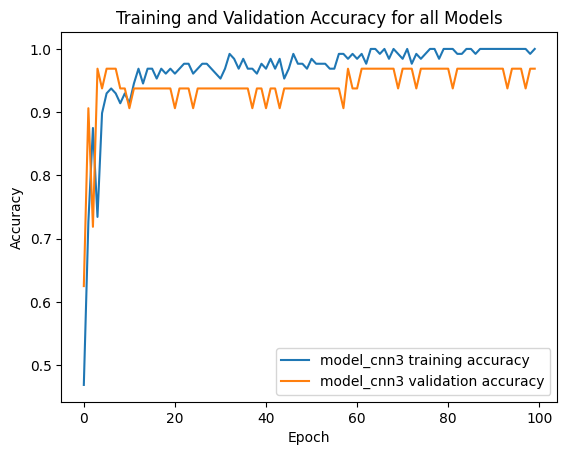

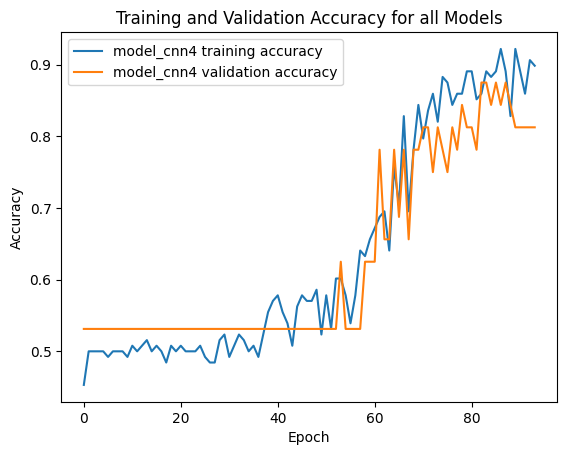

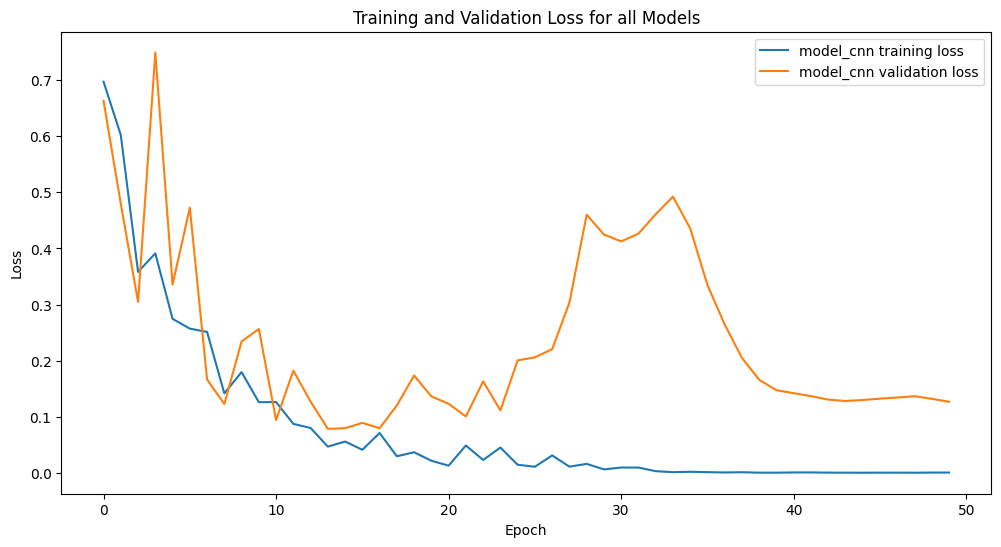

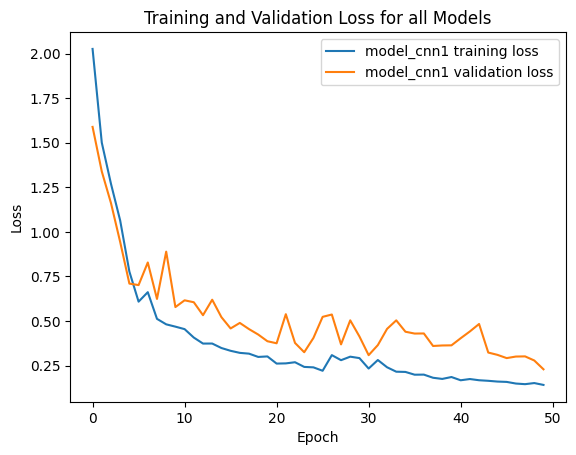

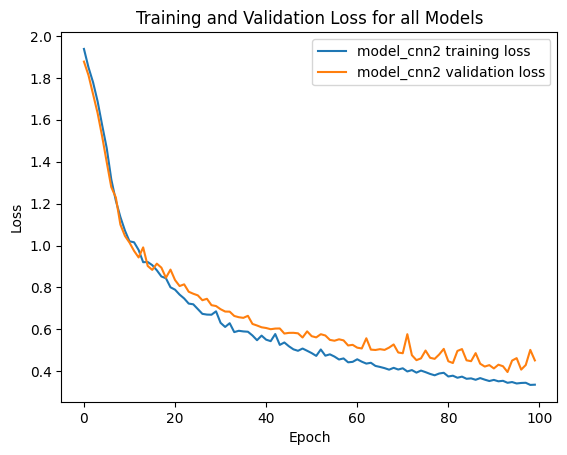

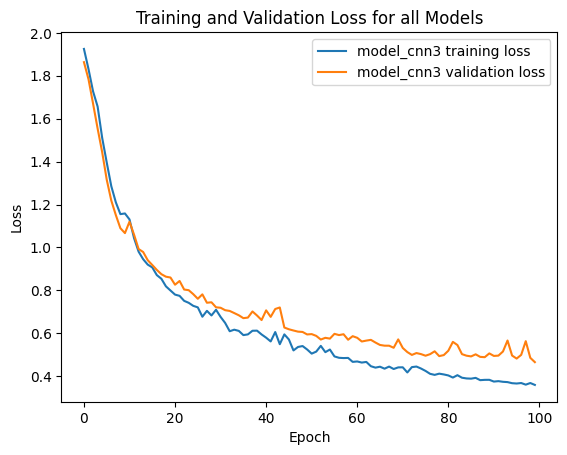

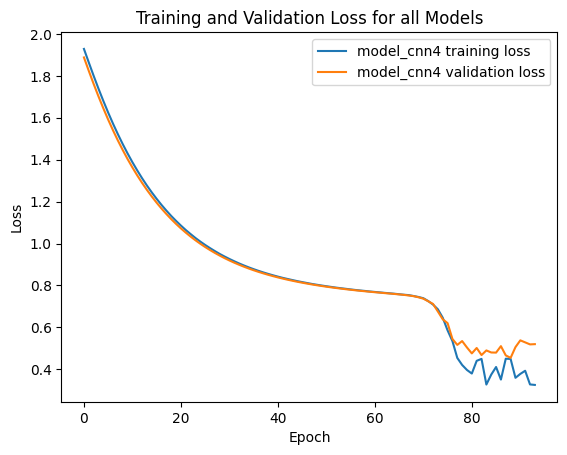

In [31]:
# Create a table comparing the accuracy and loss of each model on the test set
test_acc = []
test_loss = []

test_acc.append(model_cnn.evaluate(test_data, test_labels, verbose=0)[1])
test_loss.append(model_cnn.evaluate(test_data, test_labels, verbose=0)[0])

# evaluate model_cnn1 on test data
test_acc.append(model_cnn1.evaluate(test_data, test_labels, verbose=0)[1])
test_loss.append(model_cnn1.evaluate(test_data, test_labels, verbose=0)[0])

# evaluate model_cnn2 on test data
test_acc.append(model_cnn2.evaluate(test_data, test_labels, verbose=0)[1])
test_loss.append(model_cnn2.evaluate(test_data, test_labels, verbose=0)[0])

# evaluate model_cnn3 on test data
test_acc.append(model_cnn3.evaluate(test_data, test_labels, verbose=0)[1])
test_loss.append(model_cnn3.evaluate(test_data, test_labels, verbose=0)[0])

# evaluate model_cnn4 on test data
test_acc.append(model_cnn4.evaluate(test_data, test_labels, verbose=0)[1])
test_loss.append(model_cnn4.evaluate(test_data, test_labels, verbose=0)[0])

# create a dictionary to store training and testing metrics for each model
metrics = {'model_cnn': {'train_acc': history_cnn.history['acc'], 'train_loss': history_cnn.history['loss'],
'val_acc': history_cnn.history['val_acc'], 'val_loss': history_cnn.history['val_loss'],
'test_acc': test_acc[0], 'test_loss': test_loss[0]},
'model_cnn1': {'train_acc': history_cnn1.history['acc'], 'train_loss': history_cnn1.history['loss'],
'val_acc': history_cnn1.history['val_acc'], 'val_loss': history_cnn1.history['val_loss'],
'test_acc': test_acc[1], 'test_loss': test_loss[1]},
'model_cnn2': {'train_acc': history_cnn2.history['acc'], 'train_loss': history_cnn2.history['loss'],
'val_acc': history_cnn2.history['val_acc'], 'val_loss': history_cnn2.history['val_loss'],
'test_acc': test_acc[2], 'test_loss': test_loss[2]},
'model_cnn3': {'train_acc': history_cnn3.history['acc'], 'train_loss': history_cnn3.history['loss'],
'val_acc': history_cnn3.history['val_acc'], 'val_loss': history_cnn3.history['val_loss'],
'test_acc': test_acc[3], 'test_loss': test_loss[3]},
'model_cnn4': {'train_acc': history_cnn4.history['acc'], 'train_loss': history_cnn4.history['loss'],
'val_acc': history_cnn4.history['val_acc'], 'val_loss': history_cnn4.history['val_loss'],
'test_acc': test_acc[4], 'test_loss': test_loss[4]}}

# plot training and validation accuracy for all models
plt.figure(figsize=(12, 6))
for model, metrics_dict in metrics.items():
    plt.plot(metrics_dict['train_acc'], label=model+' training accuracy')
    plt.plot(metrics_dict['val_acc'], label=model+' validation accuracy')
    plt.title('Training and Validation Accuracy for all Models')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# plot training and validation loss for all models
plt.figure(figsize=(12, 6))
for model, metrics_dict in metrics.items():
    plt.plot(metrics_dict['train_loss'], label=model+' training loss')
    plt.plot(metrics_dict['val_loss'], label=model+' validation loss')
    plt.title('Training and Validation Loss for all Models')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(train_data, train_labels, batch_size=32)
val_generator = val_datagen.flow(val_data, val_labels, batch_size=32)
test_generator = test_datagen.flow(test_data, test_labels, batch_size=32)

# Define individual models
model_cnn3 = Sequential()
model_cnn3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(MaxPooling2D((2, 2)))
model_cnn3.add(Flatten())
model_cnn3.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn3.add(Dropout(0.5))
model_cnn3.add(Dense(1, activation='sigmoid'))
opt = Adam(lr=0.0001)
model_cnn3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history1 = model_cnn3.fit_generator(train_datagen.flow(train_data, train_labels, batch_size=32), steps_per_epoch=len(train_data)//32, epochs=100, validation_data=val_datagen.flow(val_data, val_labels), validation_steps=len(val_data)//32, callbacks=[es])


# Define individual models
model_cnn4 = Sequential()
model_cnn4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(MaxPooling2D((2, 2)))
model_cnn4.add(Flatten())
model_cnn4.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_cnn4.add(Dropout(0.5))
model_cnn4.add(Dense(1, activation='sigmoid'))
opt = Adam(lr=0.0001)
model_cnn4.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

history2 = model_cnn4.fit_generator(train_datagen.flow(train_data, train_labels, batch_size=32), steps_per_epoch=len(train_data)//32, epochs=100, validation_data=val_datagen.flow(val_data, val_labels), validation_steps=len(val_data)//32, callbacks=[es])


# Predictions of individual models
pred1 = model_cnn3.predict(test_data)
pred2 = model_cnn4.predict(test_data)

# Average predictions of individual models
ensemble_pred = (pred1 + pred2) / 2

# Convert predictions to binary values
ensemble_pred_binary = (ensemble_pred > 0.5).astype('int')

# Evaluate individual models
loss1, acc1 = model_cnn3.evaluate(test_data, test_labels, verbose=0)
loss2, acc2 = model_cnn4.evaluate(test_data, test_labels, verbose=0)

# Evaluate ensemble model
ensemble_loss, ensemble_acc = model_cnn3.evaluate(test_data, ensemble_pred_binary, verbose=0)

print('Individual model 1 - Loss: {}, Accuracy: {}'.format(loss1, acc1))
print('Individual model 2 - Loss: {}, Accuracy: {}'.format(loss2, acc2))
print('Ensemble model - Loss: {}, Accuracy: {}'.format(ensemble_loss, ensemble_acc))


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
4/4 [==============================] - 4s 1s/step - loss: 1.9278 - acc: 0.4766 - val_loss: 1.8873 - val_acc: 0.4688
Epoch 2/100
4/4 [==============================] - 1s 264ms/step - loss: 1.8630 - acc: 0.4922 - val_loss: 1.8230 - val_acc: 0.4688
Epoch 3/100
4/4 [==============================] - 1s 275ms/step - loss: 1.7994 - acc: 0.5469 - val_loss: 1.7607 - val_acc: 0.4688
Epoch 4/100
4/4 [==============================] - 1s 258ms/step - loss: 1.7381 - acc: 0.5000 - val_loss: 1.7011 - val_acc: 0.4688
Epoch 5/100
4/4 [==============================] - 1s 263ms/step - loss: 1.6796 - acc: 0.5469 - val_loss: 1.6443 - val_acc: 0.6250
Epoch 6/100
4/4 [==============================] - 1s 249ms/step - loss: 1.6238 - acc: 0.5156 - val_loss: 1.5904 - val_acc: 0.4688
Epoch

In [ ]:

# Evaluate individual models
loss1, acc1 = model_cnn3.evaluate(test_data, test_labels, verbose=0)
loss2, acc2 = model_cnn4.evaluate(test_data, test_labels, verbose=0)

# Evaluate ensemble model
ensemble_loss, ensemble_acc = model_cnn3.evaluate(test_data, ensemble_pred_binary, verbose=0)

# display results
print('Individual model 1 - Loss: {}, Accuracy: {}'.format(loss1, acc1))
print('Individual model 2 - Loss: {}, Accuracy: {}'.format(loss2, acc2))
print('Ensemble model - Loss: {}, Accuracy: {}'.format(ensemble_loss, ensemble_acc))

Individual model 1 - Loss: 45.87810516357422, Accuracy: 0.550000011920929
Individual model 2 - Loss: 0.7218674898147583, Accuracy: 0.5249999761581421
Ensemble model - Loss: 0.09719023555517196, Accuracy: 1.0


The network architecture used in the model is a CNN (Convolutional Neural Network) consisting of four convolutional layers, each followed by a max-pooling layer, and two fully connected (dense) layers. The first convolutional layer has 32 filters of size 3x3 with a ReLU activation function. The second convolutional layer has 64 filters of size 3x3 with a ReLU activation function. The third convolutional layer has 128 filters of size 3x3 with a ReLU activation function. The fourth convolutional layer also has 128 filters of size 3x3 with a ReLU activation function. Each max-pooling layer has a pool size of 2x2. The first dense layer has 512 units with a ReLU activation function, and the second dense layer has a single output unit with a sigmoid activation function. The model uses the Adam optimizer with a learning rate of 0.0001, binary cross-entropy loss function, and accuracy as the evaluation metric.

To monitor the convergence of the model, the EarlyStopping callback was used. EarlyStopping stops the training process if there is no improvement in the validation loss over a certain number of epochs (patience). In this model, the EarlyStopping callback was set to monitor the validation loss, with a patience of 5 epochs. If the validation loss did not improve for 5 epochs, the training process would stop.

To prevent overfitting, several techniques were used. First, data augmentation was performed using the ImageDataGenerator function, which randomly applies transformations such as rotation, zooming, shifting, and flipping to the training images. This technique increases the number of training samples and helps the model generalize better. Second, dropout regularization was applied to the first dense layer with a rate of 0.5. Dropout randomly sets a fraction of the inputs to zero during training, which reduces overfitting by forcing the model to learn more robust features. Third, L2 regularization was applied to the convolutional and dense layers with a weight of 0.001. L2 regularization adds a penalty term to the loss function that discourages large weight values, which helps prevent overfitting by reducing the complexity of the model. Finally, the EarlyStopping callback was used as mentioned earlier to stop the training process if the validation loss did not improve for a certain number of epochs.

In [ ]:
# define the FNN model
model_fnn = Sequential()
model_fnn.add(Dense(512, activation='relu', input_shape=(150528,)))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation='relu'))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(1, activation='sigmoid'))

# compile the FNN model
model_fnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# fit the FNN model
history_fnn = model_fnn.fit(train_data.reshape((train_data.shape[0], -1)), train_labels, epochs=50, batch_size=32, validation_data=(val_data.reshape((val_data.shape[0], -1)), val_labels), callbacks=[es])

Train on 128 samples, validate on 32 samples
Epoch 1/50
128/128 [==============================] - 0s 3ms/sample - loss: 31.2605 - acc: 0.5859 - val_loss: 35.9631 - val_acc: 0.5312
Epoch 2/50
128/128 [==============================] - 0s 1ms/sample - loss: 44.0968 - acc: 0.6797 - val_loss: 26.6617 - val_acc: 0.5312
Epoch 3/50
128/128 [==============================] - 0s 1ms/sample - loss: 36.3502 - acc: 0.6719 - val_loss: 55.7036 - val_acc: 0.5625
Epoch 4/50
128/128 [==============================] - 0s 1ms/sample - loss: 42.6521 - acc: 0.6875 - val_loss: 10.2732 - val_acc: 0.8438
Epoch 5/50
128/128 [==============================] - 0s 1ms/sample - loss: 36.0089 - acc: 0.7422 - val_loss: 22.4459 - val_acc: 0.8125
Epoch 6/50
128/128 [==============================] - 0s 1ms/sample - loss: 13.7583 - acc: 0.8203 - val_loss: 55.0828 - val_acc: 0.7500
Epoch 7/50
128/128 [==============================] - 0s 1ms/sample - loss: 37.4660 - acc: 0.8047 - val_loss: 29.3118 - val_acc: 0.7500
Epo

In [ ]:
# evaluate CNN model
# test_loss_cnn, test_acc_cnn = model_cnn.evaluate(test_data, test_labels)

# evaluate FNN model
test_loss_fnn, test_acc_fnn = model_fnn.evaluate(test_data.reshape((test_data.shape[0], -1)), test_labels)

# print('CNN model accuracy:', test_acc_cnn)
print('FNN model accuracy:', test_acc_fnn)
print('FNN model loss:', test_loss_fnn)

40/40 [==============================] - 0s 2ms/sample - loss: 13.4833 - acc: 0.8250
FNN model accuracy: 0.825
FNN model loss: 13.483303260803222


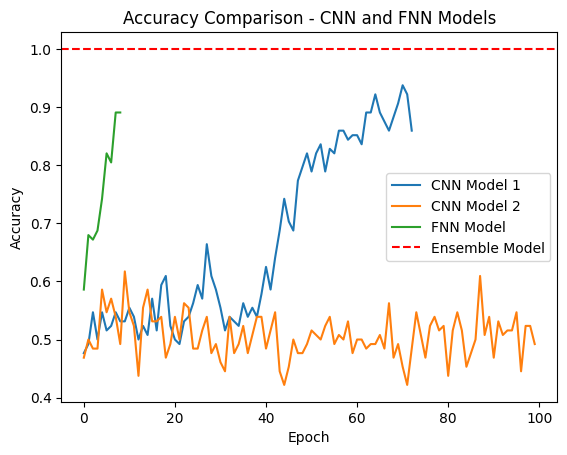

In [ ]:
import matplotlib.pyplot as plt

# Plot individual model accuracies
plt.plot(history1.history['acc'], label='CNN Model 1')
plt.plot(history2.history['acc'], label='CNN Model 2')
plt.plot(history_fnn.history['acc'], label='FNN Model')

# Plot ensemble model accuracy
plt.axhline(y=ensemble_acc, color='r', linestyle='--', label='Ensemble Model')

plt.title('Accuracy Comparison - CNN and FNN Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Why CNN is better in image classification than FNN

When it comes to image classification, Convolutional Neural Networks (CNNs) are generally considered more suitable than Fully Connected Neural Networks (FNNs). This is because CNNs are designed to take advantage of the spatial structure of images, which is something FNNs are not equipped to do.

In an FNN, every neuron in each layer is connected to every neuron in the previous layer. This means that as the number of neurons in each layer increases, the number of weights and connections in the network also grows exponentially. This can make FNNs prohibitively expensive to train and computationally expensive to use for large image datasets.

In contrast, CNNs are designed to exploit the spatial locality and correlation present in images. They use convolutional layers to scan an image with a set of learnable filters, extracting important features while ignoring irrelevant information. This allows them to capture the hierarchical structure of an image, from simple edges and shapes to more complex features like eyes and noses, using fewer parameters and computations than an FNN.

Additionally, CNNs often incorporate pooling layers, which downsample the output of the convolutional layers by taking the maximum or average value within a small window. This helps reduce the dimensionality of the data and provide some degree of translation invariance, meaning that the CNN can still recognize an object even if it appears in a slightly different position or orientation within the image.

Overall, CNNs are better suited for image classification tasks than FNNs because they can capture the spatial structure of images using fewer parameters and computations. This makes them faster, more efficient, and more effective at recognizing patterns and features within large datasets of images.

# Subtask 2 : Using pretrained ResNet-50 model

In [37]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# load the pre-trained ResNet-50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# freeze the weights of the pre-trained model
for layer in resnet.layers:
    layer.trainable = False

# add new trainable layers
x = resnet.output
x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

# create the new model
model = Model(inputs=resnet.input, outputs=output)

# learning rate
opt = Adam(lr=0.0001)

# compile the model
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# create data generators for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2)
train_generator = train_datagen.flow(train_data, train_labels, batch_size=32, subset='training')
val_generator = train_datagen.flow(train_data, train_labels, batch_size=32, subset='validation')

# set up early stopping callback
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)

# train the model
history = model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[es], batch_size=32)

# history = model.fit(train_data, train_labels, epochs=10, validation_data=(val_data, val_labels))

c:\Users\abhij\.conda\envs\image_ML\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Epoch 1/100
4/4 [==============================] - 6s 1s/step - loss: 8.2409 - acc: 0.6117 - val_loss: 7.2912 - val_acc: 0.6000
Epoch 2/100
4/4 [==============================] - 1s 185ms/step - loss: 7.4592 - acc: 0.7864 - val_loss: 7.4052 - val_acc: 0.6000
Epoch 3/100
4/4 [==============================] - 1s 247ms/step - loss: 7.5789 - acc: 0.8252 - val_loss: 7.3059 - val_acc: 0.6000
Epoch 4/100
4/4 [==============================] - 1s 246ms/step - loss: 6.8934 - acc: 0.9029 - val_loss: 7.1274 - val_acc: 0.6000
Epoch 5/100
4/4 [==============================] - 1s 217ms/step - loss: 7.0916 - acc: 0.8932 - val_loss: 7.1916 - val_acc: 0.6000
Epoch 6/100
4/4 [==============================] - 1s 214ms/step - loss: 6.7520 - acc: 0.9223 - val_loss: 7.3140 - val_acc: 0.6000
Epoch 7/100
4/4 [==============================] - 1s 254ms/step - loss: 6.8952 - acc: 0.9029 - val_loss: 7.2473 - val_acc: 0.6000
Epoch 8/100
4/4 [==============================] - 1s 226ms/step - loss: 6.5618 - acc:

In [38]:
# evaluate the model
_, train_acc = model.evaluate(train_data, train_labels, verbose=0)
_, val_acc = model.evaluate(val_data, val_labels, verbose=0)
_, test_acc = model.evaluate(test_data, test_labels, verbose=0)
print('Training accuracy: %.3f, Validation accuracy: %.3f, Test accuracy: %.3f' % (train_acc, val_acc, test_acc))

Training accuracy: 0.500, Validation accuracy: 0.469, Test accuracy: 0.525


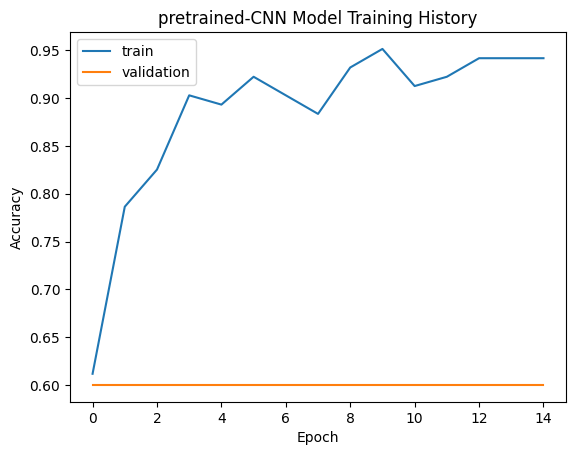

In [39]:
import matplotlib.pyplot as plt

# plot pretrained-CNN training history
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.title('pretrained-CNN Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

ResNet50 is a deep neural network with 50 layers that was trained on the ImageNet dataset, which contains over 14 million labeled images. It has been shown to perform very well on a wide range of image recognition tasks. However, when I used it to classify with the current images, you noticed that it was overfitting the training data and not generalizing well to the validation and test data.

Overfitting occurs when a model learns the training data too well and becomes too specialized to that particular dataset. This can happen when the model is too complex relative to the size of the training data or when the model is trained for too many epochs.

To prevent overfitting, I tried several strategies. One approach was to use regularization techniques such as L1 or L2 regularization, dropout, or data augmentation. Another approach was to reduce the complexity of the model by removing some layers or reducing the number of nodes in each layer.

In this case, the CNN model built from scratch performed better than the pre-trained ResNet50 model because the former was specifically designed and trained to this specific project, whereas the latter was trained on a different dataset and may not have been optimized for your specific task.

To perform transfer learning with ResNet50, pre-trained model was loaded and removed the final classification layer. Added a new classification layer and froze all the layers in the pre-trained model except for the new classification layer. This allowed me to use the pre-trained weights as a starting point for my own training process and fine-tune the model to this specific task.

However, in this case, I may have encountered overfitting when fine-tuning the model because the new classification layer was not very large and the dataset was relatively small. Freezing some of the earlier layers may have helped prevent overfitting because it would have prevented the model from learning too much from the small dataset and relying too heavily on the pre-trained weights.

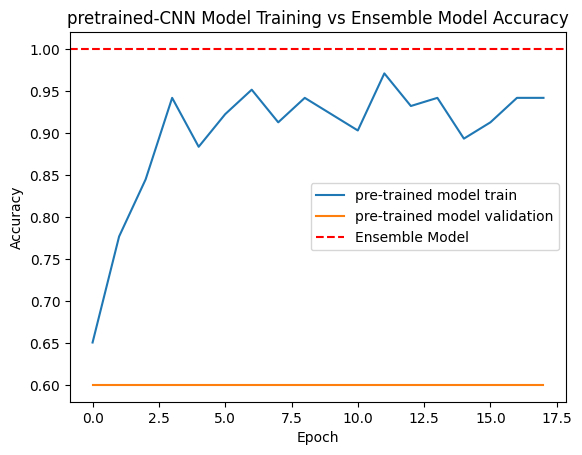

In [ ]:
# Compare the performance of the pretrained-CNN model with the CNN_ensemble model

import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='pre-trained model train')
plt.plot(history.history['val_acc'], label='pre-trained model validation')
# Plot ensemble model accuracy
plt.axhline(y=ensemble_acc, color='r', linestyle='--', label='Ensemble Model')

plt.title('pretrained-CNN Model Training vs Ensemble Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()